### 一、案例背景

主要存在问题：数据分析以及需考虑饭卡消费和日期之间的关系

In [680]:
# 导入相关的库
import pandas as pd
import seaborn as sns
import missingno #专门用做缺失值的可视化处理库
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn import preprocessing  # 归一化时用到

#导入数据拆分算法train_test_split进行数据集的拆分
from sklearn.model_selection import train_test_split

# 不用写plt.show()
%matplotlib inline
import warnings
# filter warnings
warnings.filterwarnings('ignore')

### 二、获取数据

In [681]:
data = pd.read_csv("./原始数据.csv")

##### 2.1 查看数据集的前10行

In [682]:
data.head(10)

,amount,sex,month,day,grade
0,30.9,female,3.0,1.0,3.0
1,29.2,name,3.0,1.0,2.0
2,31.0,female,3.0,1.0,1.0
3,NaN,name,4.0,1.0,4.0
4,31.8,female,5.0,1.0,1.0
5,27.7,name,5.0,1.0,4.0
6,28.0,female,4.0,1.0,1.0
7,28.1,name,5.0,1.0,2.0
8,30.6,female,4.0,1.0,3.0
9,29.8,name,3.0,1.0,4.0


##### 2.2 可视化数据，获取更多直观的信息

    初步绘制一个日期与饭卡消费的分布图。

Text(0.5, 1.0, '日期与饭卡消费的散点图（胡代金）')

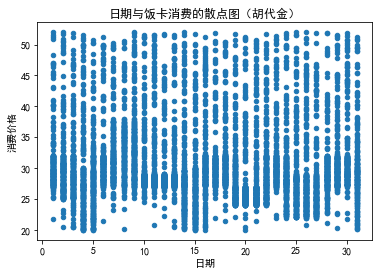

In [683]:
# 显示中文
plt.rcParams['font.family'] = 'SimHei'
# 显示负号
plt.rcParams['axes.unicode_minus'] = False

data.plot(kind="scatter", x="day", y="amount")

plt.xlabel("日期")
plt.ylabel("消费价格")
plt.title("日期与饭卡消费的散点图（胡代金）")

    将alpha 设置为0.1，显示高密度点的区域，凸显出集中的饭卡消费价格

Text(0.5, 1.0, '日期与饭卡消费的散点图（胡代金）')

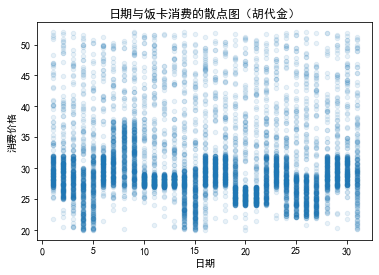

In [684]:
data.plot(kind="scatter", x="day", y="amount", alpha = 0.1)
plt.xlabel("日期")
plt.ylabel("消费价格")
plt.title("日期与饭卡消费的散点图（胡代金）")

    为了更加图像能够凸显更多的信息，将每个饭卡消费价格的的人数作为图中每个圆的半径大小，饭卡消费的中位数表示圆的颜色，使用预定义颜色表 "jet" ，颜色由紫（低消费）到红（高消费）。

Text(0.5, 1.0, '日期与饭卡消费的热点图（胡代金）')

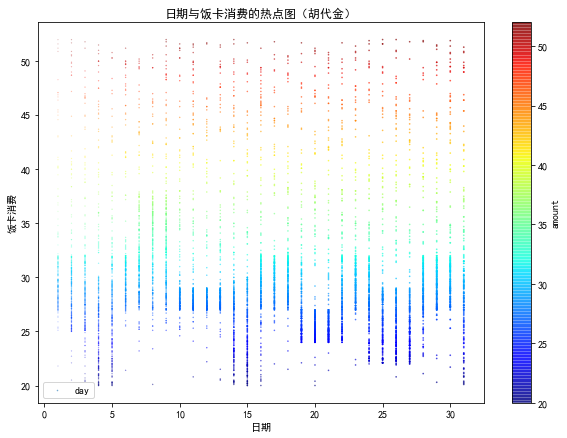

In [685]:
data.plot(kind="scatter", x="day", y="amount", alpha = 0.6, 
          s=data["day"]/50, label="day", figsize=(10,7),
             c="amount", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.xlabel("日期")
plt.ylabel("饭卡消费")
plt.title("日期与饭卡消费的热点图（胡代金）")

##### 2.3 将数据按照饭卡消费的价格升序排序，可以更方便的观看和进行数据处理，排序后继续查看数据的前10行

In [686]:
data.sort_values(by=['amount'],inplace=True,ascending=True)
data.head(10)

,amount,sex,month,day,grade
4369,20.0,male,3.0,15.0,2.0
2292,20.0,female,4.0,5.0,3.0
722,20.0,female,4.0,16.0,1.0
2205,20.0,male,5.0,4.0,1.0
2188,20.0,male,4.0,4.0,4.0
4266,20.0,female,5.0,15.0,1.0
196,20.0,female,4.0,5.0,3.0
5406,20.0,male,5.0,20.0,1.0
141,20.0,name,3.0,4.0,2.0
4208,20.1,male,5.0,14.0,2.0


查看数据的大小

In [687]:
data.shape

(7521, 5)

利用`info()`函数查看数据的各种信息

In [688]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7521 entries, 4369 to 7184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  7499 non-null   float64
 1   sex     7497 non-null   object 
 2   month   7494 non-null   float64
 3   day     7504 non-null   float64
 4   grade   7510 non-null   float64
dtypes: float64(4), object(1)
memory usage: 352.5+ KB


数据类型

In [689]:
data.type = data.dtypes
data.type.value_counts()

float64    4
object     1
dtype: int64

缺失数据统计

In [690]:
data.isna().sum()

amount    22
sex       24
month     27
day       17
grade     11
dtype: int64

In [691]:
# 训练数据中的空值排序
data.isnull().sum().sort_values(ascending=False).head()

month     27
sex       24
amount    22
day       17
grade     11
dtype: int64

可视化缺失的数据

Text(0.5, 1.0, '数据缺失值的可视化图（胡代金）')

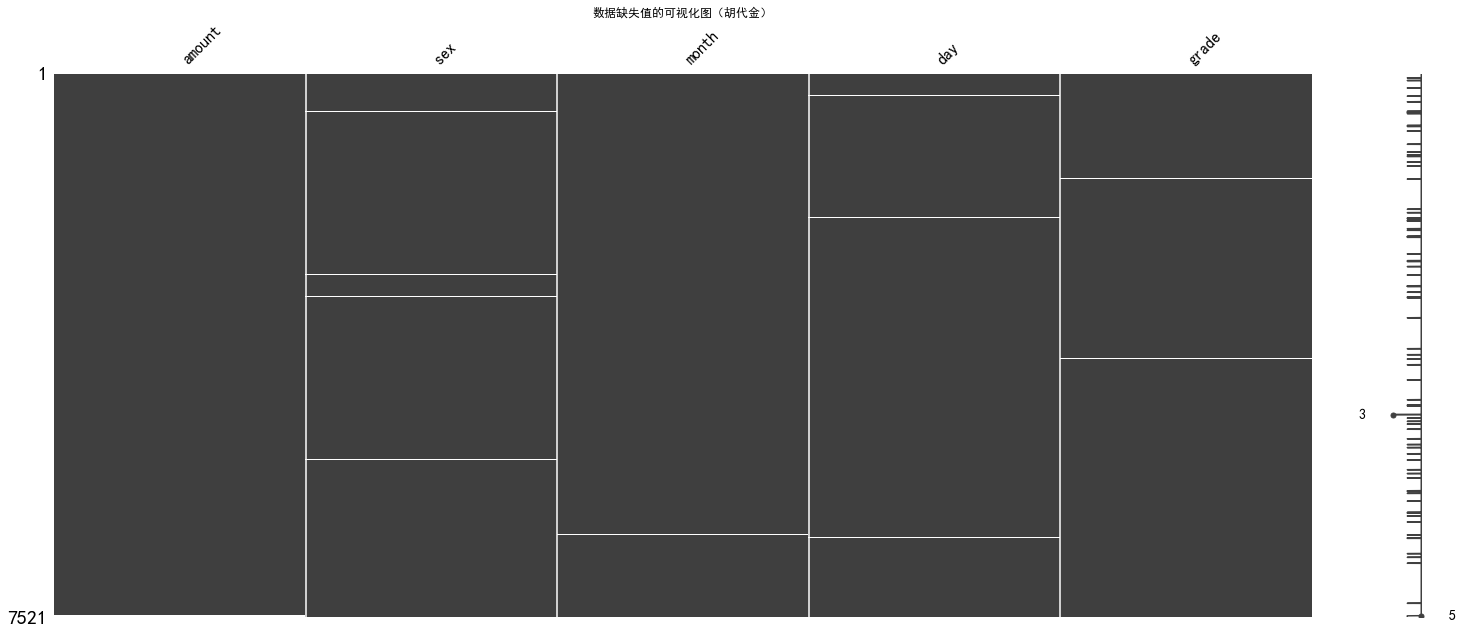

In [692]:
# 使用Misingno可视化缺失数据
missingno.matrix(data)
plt.title("数据缺失值的可视化图（胡代金）")

使用热力图查看特征之间的相互关系,可以看到各个字段之间的相关性并不强

Text(0.5, 1.0, '不同字段相关系数的热力图（胡代金）')

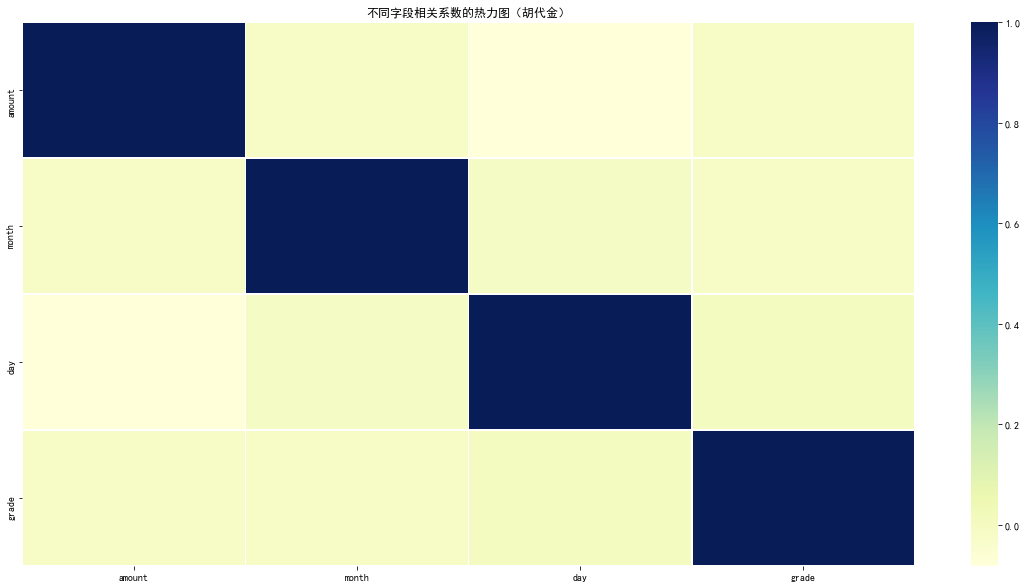

In [693]:
# 使用热力图查看特征之间的相互关系
corrmat = data.corr(method='spearman') # 计算不同数据之间的相系数
plt.figure(figsize=(20,10))
sns.heatmap(corrmat,cmap="YlGnBu", linewidths=.5)
plt.title("不同字段相关系数的热力图（胡代金）")

### 三、数据分析

##### 3.1 加载训练集和测试集

In [694]:
train_data = pd.read_csv("./训练集.csv")
test_data = pd.read_csv("./测试集.csv")

##### 3.2 训练数据分析

训练数据前10条数据

In [695]:
train_data.head(10)

,amount,sex,month,day,grade
0,28.2,female,3.0,1.0,1.0
1,28.0,female,5.0,1.0,1.0
2,27.0,female,5.0,1.0,1.0
3,27.2,female,3.0,1.0,4.0
4,29.6,female,5.0,1.0,2.0
5,29.3,female,3.0,1.0,4.0
6,27.6,female,4.0,1.0,1.0
7,29.5,female,3.0,1.0,3.0
8,31.4,female,4.0,1.0,4.0
9,29.1,female,5.0,1.0,3.0


训练数据大小

In [696]:
train_data.shape

(6041, 5)

利用`info()`函数查看训练数据的统计信息

In [697]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  6026 non-null   float64
 1   sex     6024 non-null   object 
 2   month   6021 non-null   float64
 3   day     6028 non-null   float64
 4   grade   6034 non-null   float64
dtypes: float64(4), object(1)
memory usage: 236.1+ KB


训练数据的类型

In [698]:
train_data.dtypes.value_counts()

float64    4
object     1
dtype: int64

训练数据缺失值的统计类型

In [699]:
# 训练数据中的空值排序
train_data.isnull().sum().sort_values(ascending=False).head()

month     20
sex       17
amount    15
day       13
grade      7
dtype: int64

训练数据的缺失值可视化

Text(0.5, 1.0, '训练数据缺失值的可视化图（胡代金）')

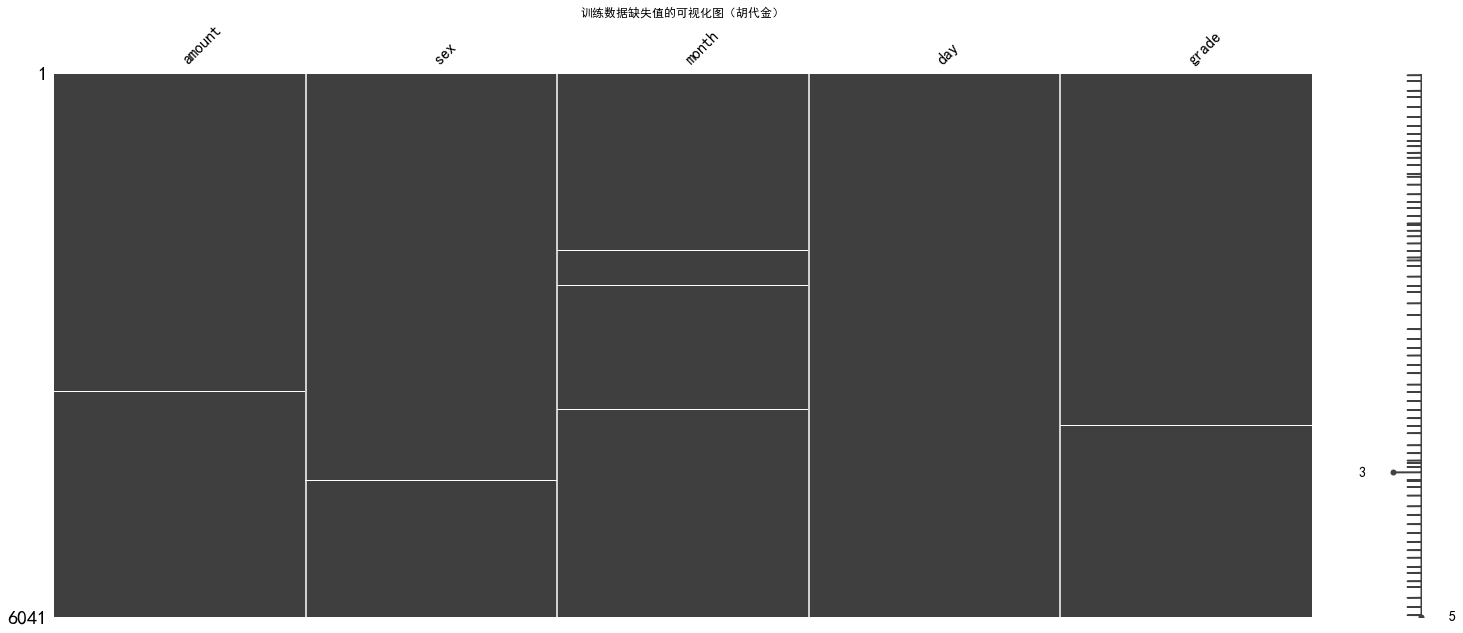

In [700]:
missingno.matrix(train_data)
plt.title("训练数据缺失值的可视化图（胡代金）")

训练数据缺失值的相关性分析

Text(0.5, 1.0, '训练数据缺失值的相关性分析图（胡代金）')

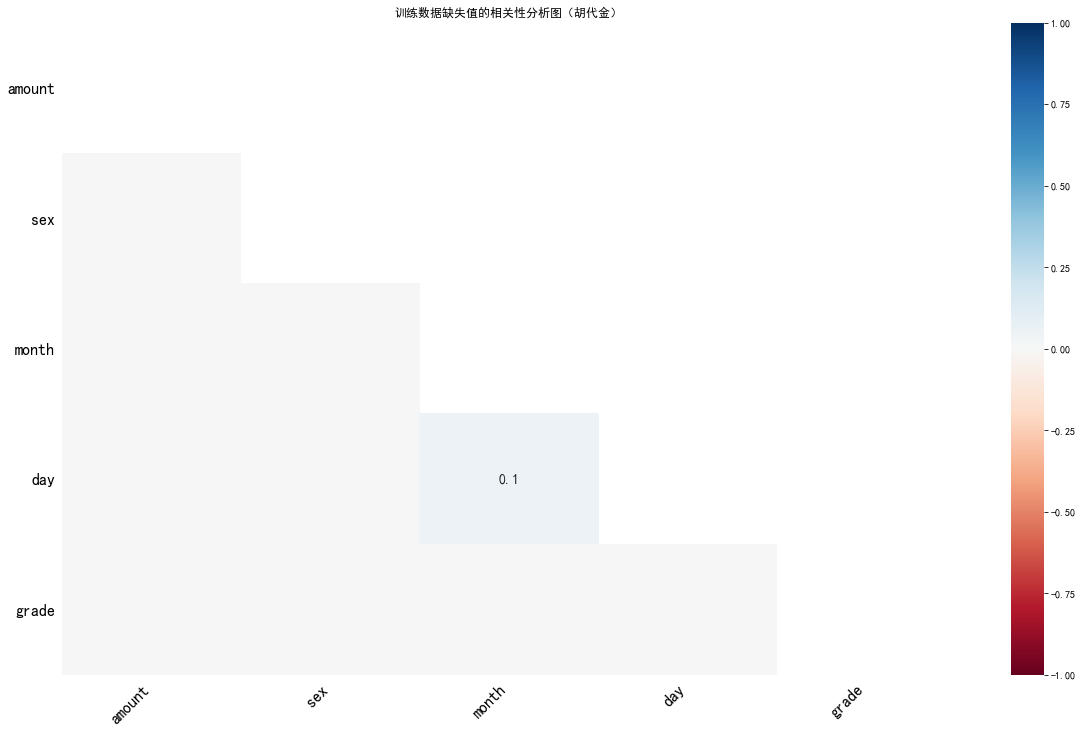

In [701]:
missingno.heatmap(train_data)
plt.title("训练数据缺失值的相关性分析图（胡代金）")

训练数据标签分布柱状图

Text(0.5, 1.0, '训练数据消费金额分布柱状图（胡代金）')

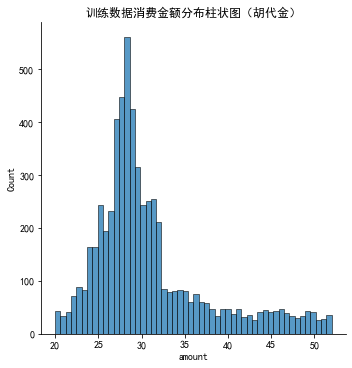

In [702]:
sns.displot(train_data['amount'])
plt.title("训练数据消费金额分布柱状图（胡代金）")

Text(0.5, 1.0, '不同字段相关系数的热力图（胡代金）')

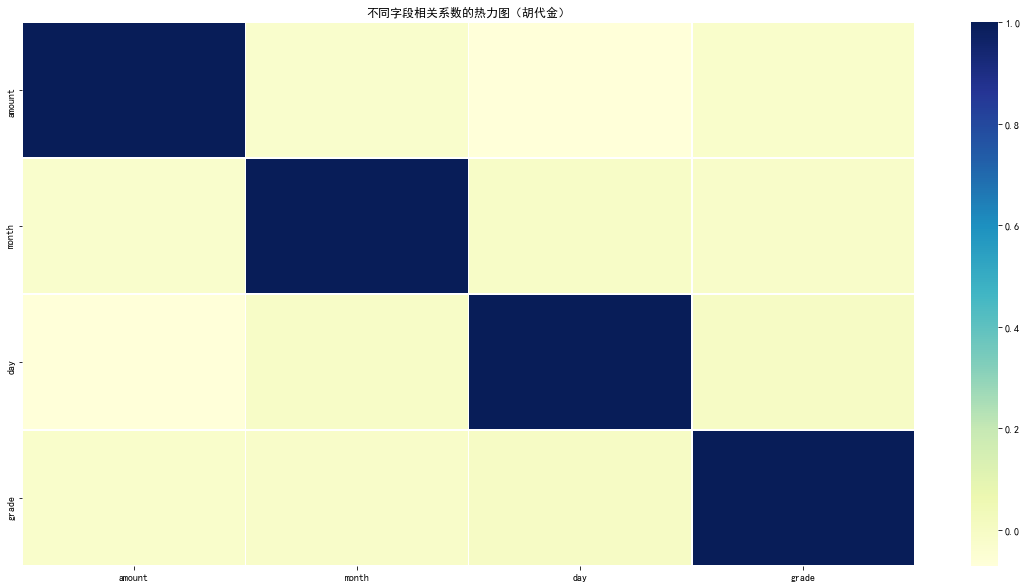

In [703]:
# 使用热力图查看特征之间的相互关系
corrmat = train_data.corr(method='spearman') # 计算不同数据之间的相系数
plt.figure(figsize=(20,10))
sns.heatmap(corrmat,cmap="YlGnBu", linewidths=.5)
plt.title("不同字段相关系数的热力图（胡代金）")

##### 3.3 测试数据分析

测试数据前10条数据

In [704]:
test_data.head(10)

,amount,sex,month,day,grade
0,30.9,female,3.0,1.0,3.0
1,29.2,name,3.0,1.0,2.0
2,31.0,female,3.0,1.0,1.0
3,NaN,name,4.0,1.0,4.0
4,31.8,female,5.0,1.0,1.0
5,27.7,name,5.0,1.0,4.0
6,28.0,female,4.0,1.0,1.0
7,28.1,name,5.0,1.0,2.0
8,30.6,female,4.0,1.0,3.0
9,29.8,name,3.0,1.0,4.0


测试数据大小

In [705]:
test_data.shape

(1480, 5)

利用`info()`函数查看测试数据的统计信息

In [706]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  1473 non-null   float64
 1   sex     1473 non-null   object 
 2   month   1473 non-null   float64
 3   day     1476 non-null   float64
 4   grade   1476 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.9+ KB


测试数据的类型

In [707]:
test_data.dtypes.value_counts()

float64    4
object     1
dtype: int64

测试数据缺失值的统计类型

In [708]:
# 训练数据中的空值排序
test_data.isnull().sum().sort_values(ascending=False).head()

amount    7
sex       7
month     7
day       4
grade     4
dtype: int64

测试数据的缺失值可视化

Text(0.5, 1.0, '训练数据缺失值的可视化图（胡代金）')

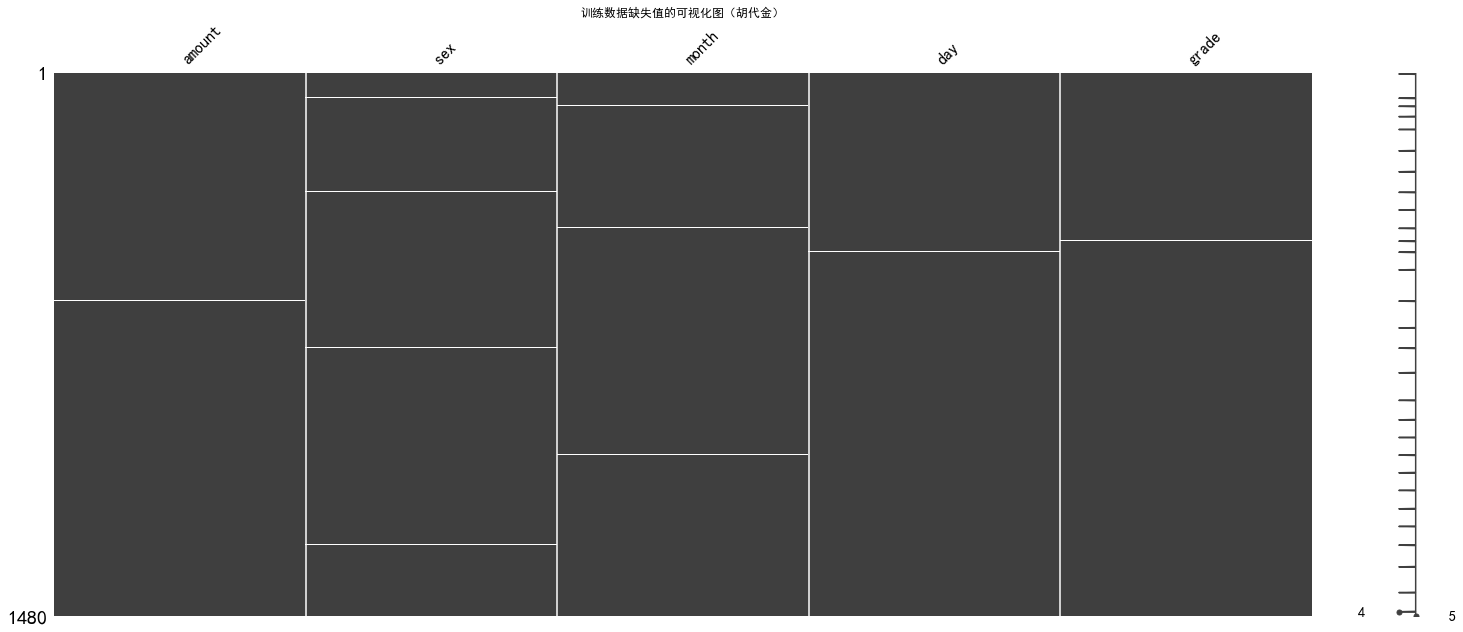

In [709]:
missingno.matrix(test_data)
plt.title("训练数据缺失值的可视化图（胡代金）")

测试数据缺失值的相关性分析

Text(0.5, 1.0, '测试数据缺失值的相关性分析图（胡代金）')

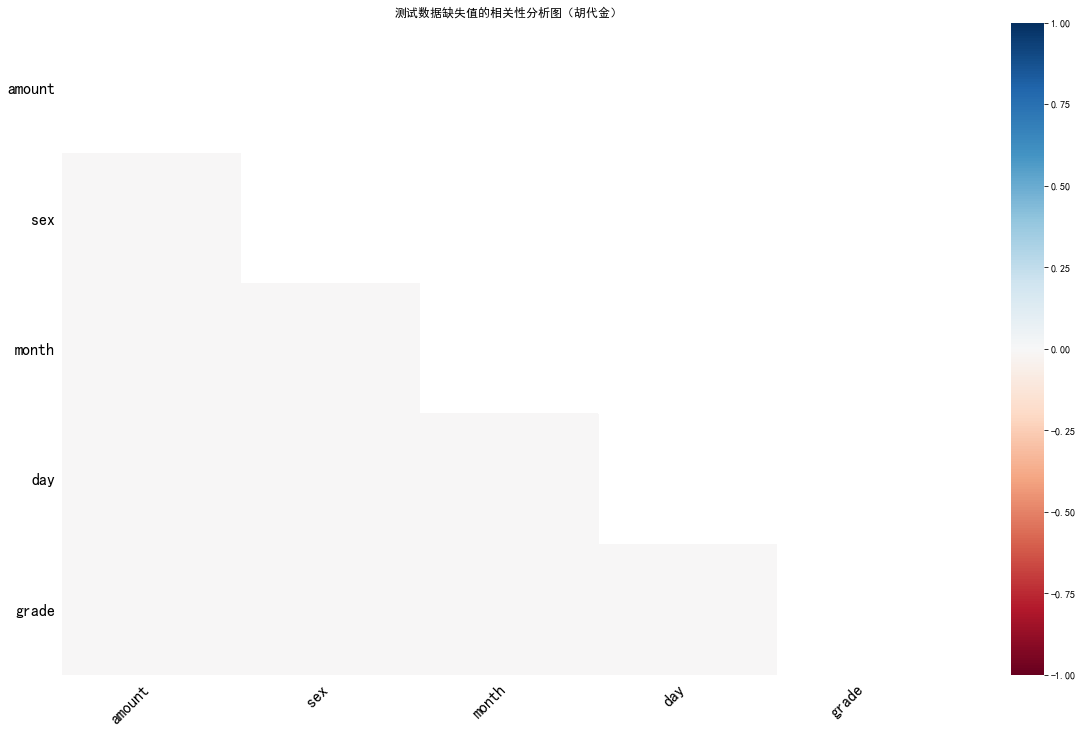

In [710]:
missingno.heatmap(test_data)
plt.title("测试数据缺失值的相关性分析图（胡代金）")

测试数据标签分布柱状图

Text(0.5, 1.0, '测试数据消费金额分布柱状图（胡代金）')

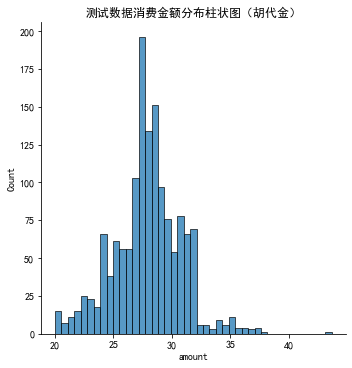

In [711]:
sns.displot(test_data['amount'])
plt.title("测试数据消费金额分布柱状图（胡代金）")

Text(0.5, 1.0, '不同字段相关系数的热力图（胡代金）')

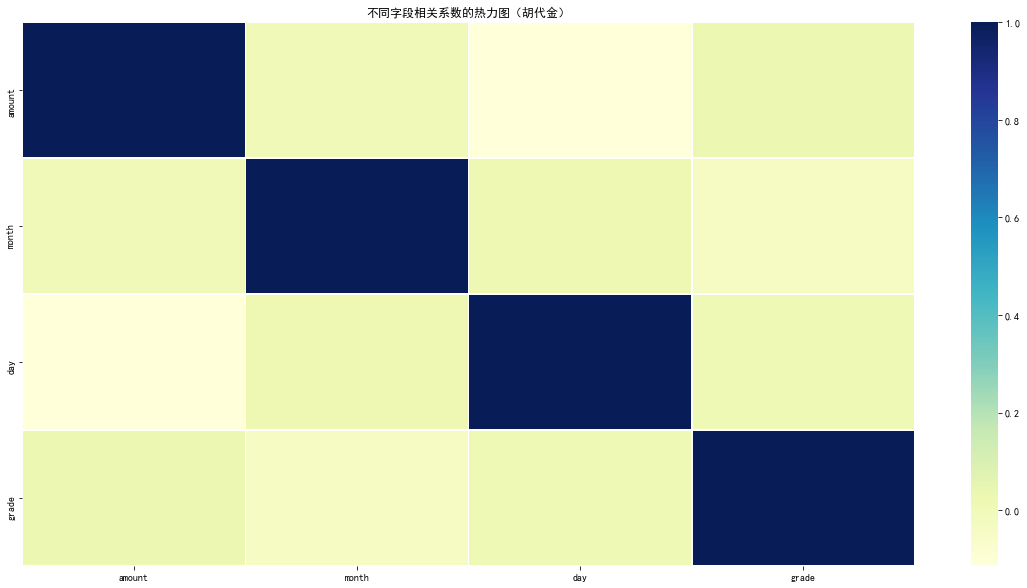

In [712]:
# 使用热力图查看特征之间的相互关系
corrmat = test_data.corr(method='spearman') # 计算不同数据之间的相系数
plt.figure(figsize=(20,10))
sns.heatmap(corrmat,cmap="YlGnBu", linewidths=.5)
plt.title("不同字段相关系数的热力图（胡代金）")

### 四、数据处理

删除有缺省值的空行

In [713]:
data.dropna(axis=0,how="any",inplace=True)
train_data.dropna(axis=0,how="any",inplace=True)
test_data.dropna(axis=0,how="any",inplace=True)

查看删除结果

In [714]:
data.isna().sum()

amount    0
sex       0
month     0
day       0
grade     0
dtype: int64

In [715]:
train_data.isna().sum()

amount    0
sex       0
month     0
day       0
grade     0
dtype: int64

In [716]:
test_data.isna().sum()

amount    0
sex       0
month     0
day       0
grade     0
dtype: int64

处理文本

将文本分类属性单纯用数字来代替，跟实际情况不符合，需要进行处理。

In [717]:
data_cat = data[["sex"]]
data_cat.value_counts()

sex   
female    3372
male      3321
name       728
dtype: int64

In [718]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
# 拟合并转换
data_cat_encoded = ordinal_encoder.fit_transform(data)
data_cat_encoded[:10]

array([[ 0.,  1.,  0., 14.,  1.],
       [ 0.,  0.,  1.,  4.,  2.],
       [ 0.,  0.,  1., 15.,  0.],
       [ 0.,  1.,  2.,  3.,  0.],
       [ 0.,  1.,  1.,  3.,  3.],
       [ 0.,  0.,  2., 14.,  0.],
       [ 0.,  0.,  1.,  4.,  2.],
       [ 0.,  1.,  2., 19.,  0.],
       [ 0.,  2.,  0.,  3.,  1.],
       [ 1.,  1.,  2., 13.,  1.]])

In [719]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
data_cat_vector= cat_encoder.fit_transform(data_cat)
data_cat_vector

<7421x3 sparse matrix of type '<class 'numpy.float64'>'
	with 7421 stored elements in Compressed Sparse Row format>

In [720]:
data_cat_vector.toarray()

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

### 五、建立模型

##### 5.1 Lasso模型

导入线性回归的库

In [721]:
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import Lasso

划分训练集和测试集

In [722]:
y = data['amount']
x = data.drop('amount',axis=1)
x = pd.get_dummies(x)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)

In [723]:
X_train = train_data.drop(['amount', 'sex'],axis=1)
X_train = X_train.values
X_train =  preprocessing.scale(X_train)

X_test = test_data.drop(['amount', 'sex'],axis=1)
X_test = X_test.values
X_test =  preprocessing.scale(X_test)

In [724]:
Y_train = train_data['amount'].values
Y_test = test_data['amount'].values

In [725]:
x_train, y_train = X_train[:, :], Y_train
x_test, y_test = X_test[:, :], Y_test

建立 Lasso 回归模型，并利用交叉验证的格子搜索技术确定最优惩罚因子；在最优惩罚因子下，分别评价 Lasso 回归在训练集和测试集的预测精度。

模型的参数

In [726]:
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

格子搜索确定最优惩罚因子

In [727]:
lasso=Lasso()
parameters={'alpha':np.arange(0.1,1,0.1)}
lasso_cv=GridSearchCV(lasso,param_grid=parameters,cv=5)
lasso_cv.fit(x_train,y_train)  
print(lasso_cv.best_params_)   
print(lasso_cv.best_score_) 

{'alpha': 0.4}
-0.01841443097339237


In [728]:
lasso=Lasso()
parameters={'alpha':np.arange(0.01,0.1,0.01)}
lasso_cv=GridSearchCV(lasso,param_grid=parameters,cv=5)
lasso_cv.fit(x_train,y_train)  
print(lasso_cv.best_params_)   
print(lasso_cv.best_score_) 

{'alpha': 0.09}
-0.02485003985780714


选择最优参数为$\alpha=0.1$

用最优惩罚因子训练模型

In [729]:
lasso=Lasso(alpha=0.1)
lasso.fit(x_train,y_train)
lasso.score(x_train,y_train)
lasso.score(x_test,y_test)

-1.1112826042750674

使用交叉验证来更好地进行评估

In [730]:
def display_scores(temp_scores):
    print("Scores:", temp_scores)
    print("Mean:", temp_scores.mean())
    print("Standard deviation:", temp_scores.std())

In [731]:
# 使用 Scikit-Learn 的 K 折交叉验证的功能
lin_scores = cross_val_score(lasso_cv, x_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6.01081605 6.96719453 6.39126043 6.3630197  7.43419712 6.20990581
 7.07140617 6.62156475 7.04360529 7.23773407]
Mean: 6.7350703926878595
Standard deviation: 0.4553568749188912


##### 5.2 决策树

模型参数

In [732]:
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor()
tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

格子搜索确定最参数

In [733]:
tree=DecisionTreeRegressor()
parameters={'max_depth':np.arange(10,20,1)}
tree_cv=GridSearchCV(tree,param_grid=parameters,cv=5)
tree_cv.fit(x_train,y_train)
print(tree_cv.best_params_)  
print(tree_cv.best_score_)

{'max_depth': 17}
-0.2529166322435715


用最优惩罚因子训练模型

In [734]:
tree=DecisionTreeRegressor(max_depth=17)
tree.fit(x_train,y_train)
tree.score(x_train,y_train)
tree.score(x_test,y_test)

-1.1706545348766788

使用交叉验证对模型进行评估

In [735]:
# 使用 Scikit-Learn 的 K 折交叉验证的功能
scores = cross_val_score(tree, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [15.01859372  7.72658782  6.18746497  7.09752446  7.88410103  6.56511216
  8.03817745  7.39633683  8.21453773  7.51185641]
Mean: 8.164029257541731
Standard deviation: 2.3640772932836467


##### 5.3 随机森林

模型参数

In [736]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(x_train, y_train)

x_predictions = forest_reg.predict(x_train)
forest_mse = mean_squared_error(y_train, x_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

6.3548318603877405

训练结果

In [737]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
print(forest_rmse_scores)
# display_scores(forest_rmse_scores)

[14.9902077   7.69846881  6.13159795  7.0600084   7.89042557  6.55883301
  8.05253962  7.35748665  8.1774831   7.50420016]


用交叉验证对模型进行评估

In [738]:
forest_scores = cross_val_score(forest_reg, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [14.9902077   7.69846881  6.13159795  7.0600084   7.89042557  6.55883301
  8.05253962  7.35748665  8.1774831   7.50420016]
Mean: 8.142125097485499
Standard deviation: 2.36449381866657


通过交叉验证可以看到lasso回归模型的均方根误差较小，但评分偏低，而决策树和随机森林的均方根误差较大，得分较高，说明决策树和随机森林的拟合程度较好，但可能存在过拟合的问题，而lasso回归模型存在欠拟合的问题

##### 5.4 微调模型

网格搜索

In [739]:
#网格搜索
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 尝试3×4=12种超参数组合
    {
      'n_estimators': [3, 10, 30], 
      'max_features': [1, 2, 3, 4]
    },
    # 之后设置bootstrap=False，再尝试2×3=6种超参数组合
    {
      'bootstrap': [False], 
      'n_estimators': [3, 10], 
      'max_features': [2, 3, 4]
    },
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_features': 2, 'n_estimators': 3}

In [740]:
#扩大取值范围，继续寻找。
param_grid = [
    {
      'n_estimators': [30, 50, 70, 90],
       'max_features': [3, 4, 5]
    },
  ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

grid_search.best_estimator_

RandomForestRegressor(max_features=3, n_estimators=30, random_state=42)

In [741]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

7.443837763867954 {'max_features': 3, 'n_estimators': 30}
7.458426750988079 {'max_features': 3, 'n_estimators': 50}
7.467514607689324 {'max_features': 3, 'n_estimators': 70}
7.458134947274913 {'max_features': 3, 'n_estimators': 90}
nan {'max_features': 4, 'n_estimators': 30}
nan {'max_features': 4, 'n_estimators': 50}
nan {'max_features': 4, 'n_estimators': 70}
nan {'max_features': 4, 'n_estimators': 90}
nan {'max_features': 5, 'n_estimators': 30}
nan {'max_features': 5, 'n_estimators': 50}
nan {'max_features': 5, 'n_estimators': 70}
nan {'max_features': 5, 'n_estimators': 90}


随机搜索

In [742]:
#随机搜索
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=3, high=5),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E0E2869AC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E0E287B0A0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [743]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

7.464013313799789 {'max_features': 3, 'n_estimators': 180}
7.452052402735697 {'max_features': 3, 'n_estimators': 15}
7.466641512006812 {'max_features': 3, 'n_estimators': 72}
7.4352162755138895 {'max_features': 3, 'n_estimators': 21}
7.468914550444007 {'max_features': 3, 'n_estimators': 122}
7.463983056976954 {'max_features': 3, 'n_estimators': 75}
7.458338476061096 {'max_features': 3, 'n_estimators': 88}
7.460441086013457 {'max_features': 3, 'n_estimators': 100}
nan {'max_features': 4, 'n_estimators': 152}
7.4612942805002955 {'max_features': 3, 'n_estimators': 150}


In [744]:
#分析最佳模型及其误差
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.218613  , 0.51282815, 0.26855885])

### 六、评估模型

lasso线性回归模型

均方根误差

In [745]:
y_pre=lasso.predict(x_test)
y_hat=lasso.predict(x_train)
Rmse_lasso=((y_hat-y_train).T.dot(y_hat-y_train)/len(y_train))**(0.5) 
Rfmse_lasso=((y_pre-y_test).T.dot(y_pre-y_test)/len(y_test))**(0.5)

画出预测值与真实值的对比

Text(0.5, 1.0, '预测值与真实值的对比图（胡代金）')

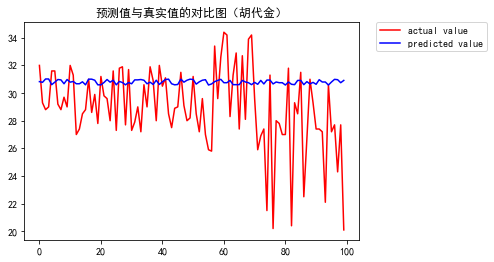

In [746]:
#选100个点进行画图
#样本太少的话，可能就不会包含某个属性某个类别的样例，这样get_dummies之后列数就会变少

x_predict = x_test[-100:]
forcast = lasso_cv.predict(x_predict) # 预测

plt.plot(y_test[-100:], color='r' , label="actual value")  
plt.plot(forcast, color='b', label="predicted value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("预测值与真实值的对比图（胡代金）")

总结：可以通过对比图看出预测的结果还不太准确。模型的均方根误差也较大，评分也很低，模型的效果并不是很好，预测的误差较大，难以让人接受。说明我们的模型的偏差较大。
这是典型的模型对训练数据欠拟合的情况。欠拟合的情况下，往往说明这些特征无法提供足够的信息来做出更好的预测，或者是模型的本身有所欠缺。要进一步提高预测的精确程度的话，可以通过选择更强大的模型，或为算法训练提供更好的特征，尝试更多的特征维度，选择不同的参数$\lambda $，又或者减少对模型的限制的方法来实现。